In [1]:
import matplotlib as mpl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

import qs_code.stats_helper as sth
    
CI_95_FACTOR = 1.96

mpl.rcParams['figure.figsize'] = (12, 8)

# Load data
FILEPATH_DATA = "data//quantified_self_data_full.csv"
df = pd.read_csv(FILEPATH_DATA)

## Quantified Self Questions
I started out this project mostly interested in the question of whether I could predict weight gain/loss based on a few simple variables, but there were several other questions that I was interesed in as well.

1. How much water and coffee do I drink? How much do I exercise? How often do I eat out and eat sweets?

2. I feel like when I eat sweets, that I'm more likely to eat a sweet on the next day as well. Is that true?

3. Do hours of sleep the night before affect my subjective rating of how good my day was? What about weather & temperature?

4. Does my weight usually stay constant or does it drift (or oscillate)?

Let's take a look at the data and try to answer these questions one by one.

---
### How much water and coffee do I drink? How much do I exercise? How often do I eat out and eat sweets?

In [2]:
exercise_hours_per_week = np.round(7 * df.mean().Exercise / 60, 1)
sweets_per_week = np.round(7 * df.mean().Sweets, 1)
eating_out_percent_of_total_meals = np.round(100 * df.mean().EatingOut / 3, 1)

print(f"I drink an average of {df.mean().round(1).Coffee} cups/day of coffee")
print(f"I drink an average of {df.mean().round(1).Water} liters/day of water")
print(f"I exercise for an average of {exercise_hours_per_week} hours/week")
print(f"I eat on average {sweets_per_week} sweets/week")
print(f"I eat out for {eating_out_percent_of_total_meals}% of my meals")

I drink an average of 3.7 cups/day of coffee
I drink an average of 1.5 liters/day of water
I exercise for an average of 1.8 hours/week
I eat on average 3.5 sweets/week
I eat out for 20.1% of my meals


According to the top hits on my Google searches, I eat out as much as the average American, eat sweets more often than the recommended twice per week, drink an acceptable amount of water, though there seems to be little consensus on this, and drink a bit more coffee than the American average of 3 cups/day. I'm also getting more than the recommended 1.25 hours of vigorous aerobic activity/week.

---
### I feel like when I eat sweets, that I'm more likely to eat a sweet on the next day as well. Is that true?

To address this question I calculate the empirical probability that I eat sweets the day after I've already eaten sweets, which I designate as P(1|1). I count instances of eating one or more sweets on a day as 1 and no sweets as zero to generate a binary time series.

In [3]:
# Treat multiple instance of eating sweets in a day the same as one instance
sweets_binary = df.Sweets.clip(0,1).values 

# Estimate conditional probability P(1|1) and P(0|1) of sweets data
prob_1_conditional_1 = sth.get_probability_1_conditional_1(sweets_binary)

print(f"Probability of eating sweets on any given day: "
      f"P(1) = {np.round(sweets_binary.sum() / len(sweets_binary), 2)}")
print(f"Probability of eating sweets given I ate sweets on the preceding day: "
      f"P(1|1) = {np.round(prob_1_conditional_1,2)}")

Probability of eating sweets on any given day: P(1) = 0.38
Probability of eating sweets given I ate sweets on the preceding day: P(1|1) = 0.57


At first glance, the probability that I eat a sweet given I ate a sweet on the preceding day being around 60% might suggest that it isn't so significant, since we might naively assume that it should be 50% if I eat sweets at random. However since I only eat sweets on about a third of the days, the datasest is unbalanced, so random sweet eating should be closer to a value of 38% rather than 50%. Let's use bootstrapping to generate a 95% confidence interval on the value of P(1|1).

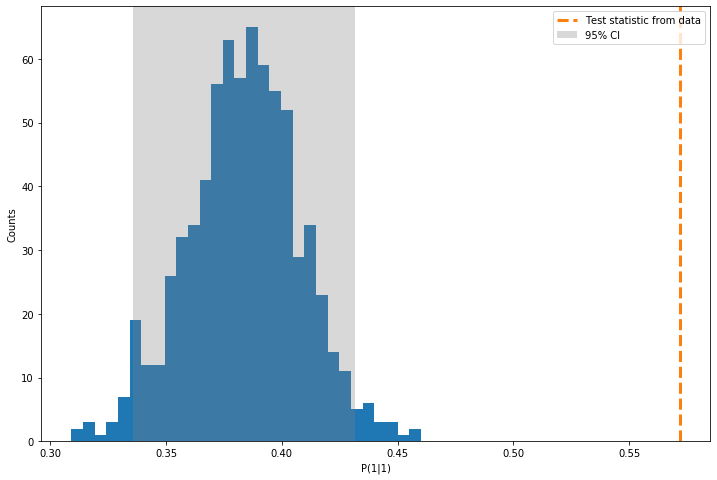

In [4]:
probs_1_conditional_1_distribution = sth.run_probability_1_conditional_1_bootstrap(sweets_binary)

sth.plot_bootstrap_histogram_with_CI_95(probs_1_conditional_1_distribution, test_statistic_value=prob_1_conditional_1)
plt.xlabel("P(1|1)")
plt.show()

The blue histogram shows 1000 bootstrap resamples from the original dataset. As expected the mean of the distribution is around the empirical probability of P(1) = 0.38, with the 95% confidence interval, shown in gray, spanning from about 0.3 to 0.4. The result P(1|1) calculated from the dataset, marked by the dashed orange line, lies far outside the distribution, so it looks like my intuition that eating sweets leads to more eating sweets is well supported by the data.

---
### Do hours of sleep the night before affect my subjective rating of how good my day was? What about weather & temperature?

To explore this question I look at correlations between how good I thought the day was and how sunny, rainy or warm that day was, and how well I slept the night before.

Expected threshold value for significant correlation: 0.07


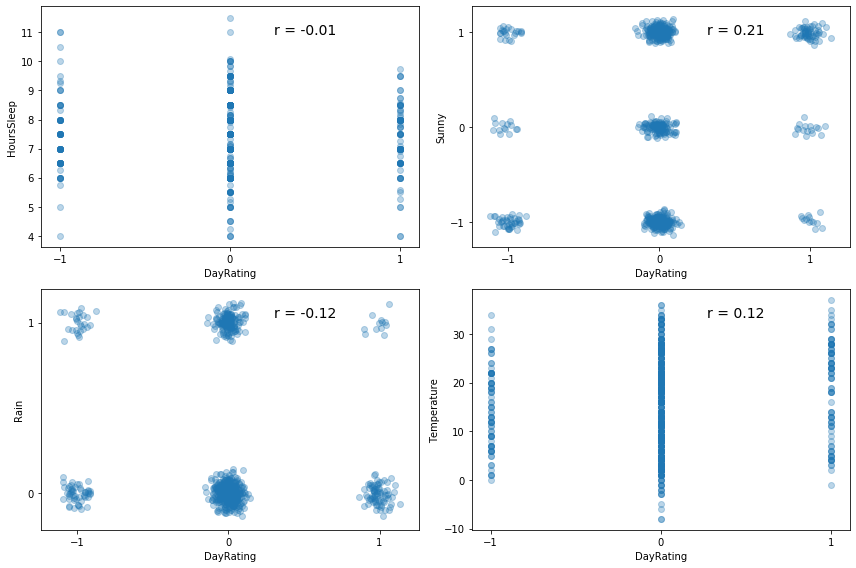

In [5]:
fields = ["HoursSleep", "Sunny", "Rain", "Temperature"]

# Add jitter to keep points from being all plotted on top of one another
x_jitter = 0.05*np.random.randn(len(df.DayRating))
y_jitter = 0.05*np.random.randn(len(df.DayRating))

print(f"Expected threshold value for significant correlation: {np.round(2 / np.sqrt(len(df)), 2)}")

for idx, field in enumerate(fields):
    correlation_coeff = df.DayRating.corr(df[field])
    plt.subplot(2, 2, idx + 1)
    plt.xlabel("DayRating")
    plt.ylabel(field)
    if field == "Sunny":
        plt.scatter(df.DayRating + x_jitter, df[field] + y_jitter, alpha=0.3)
        plt.locator_params(axis='y', nbins=3)
    elif field == "Rain":
        plt.scatter(df.DayRating + x_jitter, df[field] + y_jitter, alpha=0.3)
        plt.locator_params(axis='y', nbins=2)
    else:
        plt.scatter(df.DayRating, df[field], alpha=0.3)
    ax = plt.gca()
    plt.locator_params(axis='x', nbins=3)
    plt.text(0.7, 0.9, f"r = {np.round(correlation_coeff, 2)}", fontsize=14,
             horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

plt.tight_layout()

I've plotted the variables of interest against how good I thought the day was, adding some jitter to the values of "Sunny" and "Rain" so that all the points don't lie on top of each other. I've also plotted the Pearson correlation coefficients (denoted by r) on each of the plots. The rule of thumb is that a correlation coefficient should have a magnitude |r| > 2/sqrt(number of data points) to represent a significant effect. In this case that would correspond to a value of 0.07, so it looks like sunniness and warm temperatures are weakly but significantly correlated with good days and that sleep is not. Raininess seems to be weakly negatively correlated with the day rating. Let's bootstrap the correlation coefficients and again generate some 95% confidence intervals.  

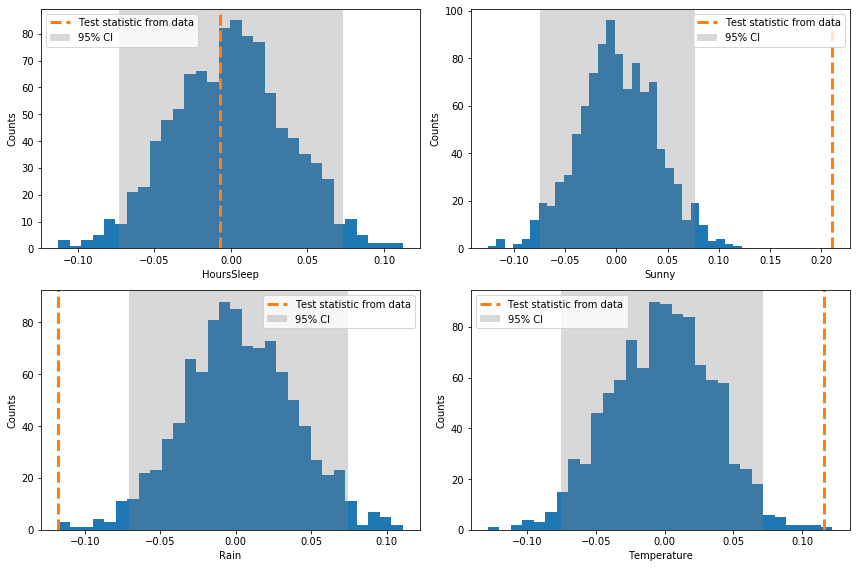

In [6]:
for idx, field in enumerate(fields):
    plt.subplot(2, 2, idx + 1)
    pearson_corr_distribution = sth.run_pearson_correlation_bootstrap(df.DayRating.values, df[field].values)
    correlation_coeff = df.DayRating.corr(df[field])
    sth.plot_bootstrap_histogram_with_CI_95(pearson_corr_distribution, test_statistic_value=correlation_coeff)
    plt.xlabel(field)
plt.tight_layout()

Again the blue histograms show 1000 bootstrap resamples of the correlation coefficient, the gray shaded region is the 95% confidence interval, and the orange line marks the correlation coefficient from the original data. As predicted by the rule of thumb, sunniness and temperature exhibit a significant positive correlation with how good I thought the day was, raininess exhibits a significant negative correlation. The amount of sleep I get the night before doesn't seem to affect how I rate my day. Though this doesn't answer the question of causality, it does demonstrate significant correlations between the weather and how I rate my day.

---
### Does my weight usually stay constant or does it drift (or oscillate)?

I was also curious how my weight changed over time, whether it just stayed constant or whether it was more dynamic.

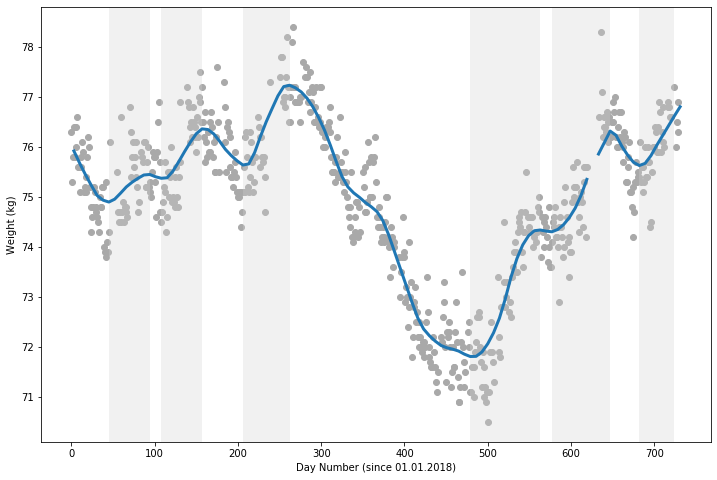

In [7]:
# Downsample weight data to get smoother trend line, due to gaps in data
weekly_weights = df.groupby(np.arange(len(df)) // 7).mean().Weight
# Get weekly day numbers and add 3 to center the day number in the middle of the week
weekly_day_number = np.arange(0,len(weekly_weights) * 7, 7) + 3 

# Get trend line and regions of increasing weight
smooth_weights = lowess(weekly_weights, weekly_day_number, frac=0.1, return_sorted=False)
increasing_weight_regions = sth.find_regions_increasing_slope(smooth_weights)
day_number = np.arange(len(df.Weight))

plt.scatter(day_number, df.Weight, c="darkgray")
plt.plot(weekly_day_number, smooth_weights, linewidth=3)
plt.xlabel("Day Number (since 01.01.2018)")
plt.ylabel("Weight (kg)")
ax = plt.gca()      
for start_idx, end_idx in increasing_weight_regions:
    ax.axvspan(weekly_day_number[start_idx], weekly_day_number[end_idx], facecolor='lightgray', alpha=0.3)

The gray point cloud is my raw weight data with a smoothed trend line in blue. The gray shaded areas highlight time periods of increasing weight, and the gaps in the data are days where I didn't weigh myself. It looks like my weight is almost always either trending up or down, rarely staying constant. Let's look at my sweet eating, eating out, and amount of exercise in the periods of increasing weight.

In [8]:
# Get the indices of the increasing weight regions in terms of the original idxs rather tan the weekly indexing
increasing_idxs = []
for tup in increasing_weight_regions:
    day_idxs = weekly_day_number[slice(*tup)]
    increasing_idxs.extend(np.arange(day_idxs[0], day_idxs[-1]).tolist())
    
# Get the indices for non-increasing regions for comparison
non_increasing_idxs = list(set(day_number) - set(increasing_idxs))

for field in ["Sweets", "EatingOut", "Exercise"]:
    bootstrap_distribution = sth.get_bootstrap_distribution(df[field][non_increasing_idxs].to_numpy(), 1000) 
    mu = bootstrap_distribution.mean(axis=1).mean()
    sigma = bootstrap_distribution.mean(axis=1).std()
    print(f"{field}: Avg. in increasing regions = {np.round(df[field][increasing_idxs].mean(), 2)}")
    print(f" Avg. in non-increasing regions = {np.round(df[field][non_increasing_idxs].mean(), 2)}, "
         f"with 95% CI bounds of ({np.round(mu - CI_95_FACTOR * sigma, 2)}, {np.round(mu + CI_95_FACTOR * sigma, 2)})")
    print("-" * 100)

Sweets: Avg. in increasing regions = 0.58
 Avg. in non-increasing regions = 0.44, with 95% CI bounds of (0.37, 0.51)
----------------------------------------------------------------------------------------------------
EatingOut: Avg. in increasing regions = 0.75
 Avg. in non-increasing regions = 0.5, with 95% CI bounds of (0.44, 0.56)
----------------------------------------------------------------------------------------------------
Exercise: Avg. in increasing regions = 12.96
 Avg. in non-increasing regions = 16.81, with 95% CI bounds of (14.54, 19.04)
----------------------------------------------------------------------------------------------------


There is a significant difference between my eating out, sweet eating, and exercise habits in periods of increasing weight. This hints that eating more sweets and eating out more may lead to weight gain, and that more exercise may lead to weight loss. Surprising stuff.

### Conclusions

I think the most interesting things that came out of the analysis above were that when I eat sweets I am heavily biased towards eating sweets on the next day and that my weight is constantly drifting rather than hovering around a constant value. I'm not surprised that sunniness and warm weather lead to a better appraisal of how good a given day is, and that raininess leads to a bad appraisal, but I would have thought that hours of sleep would have had more influence. It's also not surprising that exercising less, eating out more, and eating sweets more correlate with increasing weight. Finally, even though I drink more coffee the average, I thought I drank even more, so I'm going to celebrate by making myself a coffee.